In [1210]:
import pandas as pd
import numpy as np
import json
import time
import spacy
import warnings
from fuzzywuzzy import fuzz,process
from nltk.corpus import wordnet as wn
from collections import Counter
import matplotlib.pyplot as plt
import math
import operator
import geopy.distance
import geocoder

### Read in data and construct indices

In [52]:
def read_json_data(filename, limit=100):
    """
    Reads in json data and stores in a dictionary
    Returns the dictionary
    """
    
    #Dictionary to store json items
    business_dict = {}
    
    #Limit on number of items to read in
    i=0
    
    #Open and read file
    with open(filename) as file:
        for business in file.readlines():
            if i == limit:
                break
            else:
                i+=1
                
            #Parse file line into json and store in dictionary
            biz_dict = json.loads(business)
            biz_id = biz_dict['business_id']
            del biz_dict['business_id']
            business_dict[biz_id] = biz_dict
            
    return business_dict

In [589]:
def construct_category_index(data):
    category_dict = {}
    for data_id, data_attrs in zip(data.keys(), data.values()):
        try:
            categories = data_attrs['categories'].lower().replace(',', '').split(' ')
            for category in set(categories):
                category = wn.morphy(category)
                if category in category_dict:
                    category_dict[category].append(data_id)
                else:
                    category_dict[category] = [data_id]
        except:
            pass
    return category_dict

In [875]:
def construct_maxmin_index(data, categories):
    
    attribute_ranges = {
        'latitude': [0,0],
        'longitude': [0,0],
        'stars': [0,0],
        'review_count': [0,0],
    }
    
    for business in data.values():
        attributes = ['latitude', 'longitude', 'stars', 'review_count']
        for attribute in attributes:
            value = business[attribute]
            attribute_ranges[attribute][0] = min(attribute_ranges[attribute][0], value)
            attribute_ranges[attribute][1] = max(attribute_ranges[attribute][1], value)
                
    return attribute_ranges

In [699]:
def morphize_query(query):
    return [wn.morphy(q.lower()) for q in query]

In [1423]:
class QuerySuggester:
    
    def __init__(self):
        self.attributes = {}
        
    def _sort_attributes(self, category):
        self.attributes[category] = dict(sorted(self.attributes[category].items(), key = lambda x : x[1], reverse=True))
    
    def update_attributes(self, categories, literals):
        for category in categories:
            category = wn.morphy(category.lower())
            if category not in self.attributes:
                self.attributes[category] = {}
            for literal in literals:
                attribute = literal[0]
                if attribute in self.attributes[category]:
                    self.attributes[category][attribute] += 1
                else:
                    self.attributes[category][attribute] = 1
            self._sort_attributes(category)
            
    def get_attributes(self, categories):
        results = {}
        returned_categories = []
        for category in categories:
            category = wn.morphy(category.lower())
            if category in self.attributes:
                temp = self.attributes[category]
            else:
                continue
            results = dict(list(results.items()) + list(temp.items()) + [(k, results[k] + temp[k]) for k in set(results) & set(temp)])
            returned_categories.append(category)
        print("Other users with similar searches of ", returned_categories, " have searched for some of the following attributes:")
        return dict(sorted(results.items(), key = lambda x : x[1], reverse=True))

In [1424]:
suggester = QuerySuggester()

In [1262]:
start_time = time.time()
business_yelp = read_json_data('business.json', limit=-1)
print("Execution Time: ", time.time()-start_time)

Execution Time:  8.230246782302856


In [590]:
business_categories = construct_category_index(business_yelp)

In [1278]:
#Construct max min index
maxmin_index = construct_maxmin_index(business_yelp, business_categories.keys())

### Main filtering functions

In [1263]:
business_yelp

{'1SWheh84yJXfytovILXOAQ': {'name': 'Arizona Biltmore Golf Club',
  'address': '2818 E Camino Acequia Drive',
  'city': 'Phoenix',
  'state': 'AZ',
  'postal_code': '85016',
  'latitude': 33.5221425,
  'longitude': -112.0184807,
  'stars': 3.0,
  'review_count': 5,
  'is_open': 0,
  'attributes': {'GoodForKids': 'False'},
  'categories': 'Golf, Active Life',
  'hours': None},
 'QXAEGFB4oINsVuTFxEYKFQ': {'name': 'Emerald Chinese Restaurant',
  'address': '30 Eglinton Avenue W',
  'city': 'Mississauga',
  'state': 'ON',
  'postal_code': 'L5R 3E7',
  'latitude': 43.6054989743,
  'longitude': -79.652288909,
  'stars': 2.5,
  'review_count': 128,
  'is_open': 1,
  'attributes': {'RestaurantsReservations': 'True',
   'GoodForMeal': "{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': True, 'brunch': False, 'breakfast': False}",
   'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",
   'Caters': 'True',
   'NoiseLevel': "u'loud

In [1431]:
suggester.attributes

{'japanese': {'stars': 2, 'HappyHour': 2},
 'restaurant': {'stars': 1, 'HappyHour': 1}}

In [1430]:
start_time = time.time()
q_category = 'restaurant'
q_keywords = ['japanese']
q_literals = [('stars', '>=', 4), ('HappyHour', '=', 'True')]
complete = complete_query(q_category, q_keywords, q_literals, k=100, consider_location=False)
print("Execution Time: ", time.time()-start_time)
complete

['japanese', 'restaurant']
{'restaurant': 0.69, 'japanese': 0.59, 'assistant': 0.5}
Execution Time:  1.5790672302246094


,Name,Stars,Number of Reviews,Score,City,Categories
fs5MuKWT28LAa8ql_mq43g,Bar Sake & Robata Grill,5.0,6,129.60,Las Vegas,"Sushi Bars, Nightlife, Cocktail Bars, Bars, Ja..."
5V4TsVp5S8FVDo_guJgNzw,Kage Restobar,4.5,32,129.55,Mississauga,"Japanese, Restaurants, Asian Fusion, Bars, Nig..."
grlL6zmHBOer9rPycsRhBA,Bocho Sushi,4.5,461,129.55,Las Vegas,"Bars, Sushi Bars, Nightlife, Restaurants, Japa..."
yCK1Ok69D7TSWJESZQZHiQ,Yama Sushi House,4.5,341,129.55,Phoenix,"Bars, Sushi Bars, Japanese, Restaurants, Wine ..."
JXTlt-mRrQoE2_gfijhp4g,Gangnam Street,4.5,158,129.55,Las Vegas,"Nightlife, Restaurants, Japanese, Ramen, Bars,..."
FsCujpVh9Za2Dl5MIYLCxA,Zu Izakaya Asian Kitchen,4.5,660,129.55,Tempe,"Nightlife, Izakaya, Burgers, Sushi Bars, Resta..."
1Qs8-7DUkIYrQVjBzFqdnA,Sasaki Sushi & Bar,4.5,78,129.55,Scottsdale,"Soup, Japanese, Nightlife, Restaurants, Cockta..."
5SZe-u0hyquuipQL5lbg_g,Yatai Japanese Grill & Pub,4.0,40,129.50,Las Vegas,"Pubs, Izakaya, Nightlife, Tapas/Small Plates, ..."
fN7ds9Dk4IfMsh4RT9x82w,Wok N Roll,4.0,175,129.50,Scottsdale,"Asian Fusion, Lounges, Nightlife, Sushi Bars, ..."
-sUf12Imjs68dBrmELiwzQ,Yama Izakaya,4.0,230,129.50,Charlotte,"Nightlife, Tapas Bars, Cocktail Bars, Ramen, T..."


In [1429]:
def complete_query(category, keywords, literals, k=10, consider_location=True):
        
    lat, lng = None, None
    if consider_location:
        lat,lng = geocoder.ip('me').latlng
        
    keywords.append(category)
    suggester.update_attributes(keywords, literals)
    
    #Execute category search and return business ids matching the query
    categories = category_search_index(business_categories, keywords, 'fuzzy')
    
    #Execute literal search on returned businesses
    weighted_results = literals_search(categories, business_yelp, literals, lat=lat, lng=lng)
    sorted_results = sorted(weighted_results.items(), key = lambda x : x[1], reverse=True)
    
    return expand_top_k(business_yelp, sorted_results, k)

In [1158]:
def expand_top_k(data, weighted_results, k):
    temp = pd.DataFrame(columns=['Name', 'Stars', 'Number of Reviews', 'Score', 'City', 'Categories'])
    i=0
    for result in weighted_results:
        business = data[result[0]]
        temp.loc[result[0]] = [business['name'], business['stars'], business['review_count'], result[1], business['city'], business['categories']]
        i+=1
        if i == k:
            break
    return temp

In [1317]:
def category_search_index(data, query, search_method):
    
    if type(query) != list:
            query = [query]
    query = morphize_query(query)
    print(query)
    
    if search_method == 'linear':
        matching_ids = np.array([])
        for category, data_ids in zip(data.keys(), data.values()):
            for q in query:
                if category and q in category:
                    matching_ids = np.append(matching_ids, data_ids)
        
        unique, counts = np.unique(matching_ids, return_counts=True)
        results = dict(zip(unique, counts))
        
    elif search_method == 'fuzzy':
        category_score_dict = {}
        for category, data_ids in zip(data.keys(), data.values()):
            ratio = 0
            for q in query:
                ratio += fuzz.token_sort_ratio(query, category)
            category_score_dict[category] = (ratio/len(query))/100
        category_score_dict = dict((k, v) for k,v in category_score_dict.items() if v >= (1/1.43)**len(query))
        print(category_score_dict)
        
        results = {}
        for category in category_score_dict.items():
            business_ids = data[category[0]]
            category_score = category[1]
            temp = dict((biz_id, category_score) for biz_id in business_ids)
            results = dict(list(results.items()) + list(temp.items()) + [(k, results[k] + temp[k]) for k in set(results) & set(temp)])
        
    elif search_method == 'NLP':
        for category, data_ids in zip(data.keys(), data.values()):
            print(temp.similarity(nlp(category)))
        
    return results

In [1282]:
def literals_search(weighted_dict, data, literals, lat, lng):
    
    weighted_dict_new = {}
        
    literals_parsed = []
    for literal in literals:
        literals_parsed.append(parse_literal(literal))
    
    for business,weight in weighted_dict.items(): #For KV pair of businesses
        
        business_attributes = data[business]
        weight = weight*100
        if lat and lng:
            distance = geopy.distance.vincenty((lat, lng), (business_attributes['latitude'], business_attributes['longitude'])).mi
            normalize_distance = lambda x : 2*(1 - (x / (x+3)))
            weight += normalize_distance(distance)
            
        for literal in literals_parsed: #For each query literal (attr < val)
            
            #Extract value of specified attribute
            try:
                attribute_value = business_attributes[literal[0]]
                max_value = maxmin_index[literal[0]][1]
                normalize_match = lambda val,threshold,val_max : ((val_max+val)/val_max - (threshold/val_max))/2
            except:
                try:
                    attribute_value = business_attributes['attributes'][literal[0]]
                except:
                    attribute_value = None
            
            if not attribute_value:
                continue
            
            literal_weight_factor = 1
            if literal[1](attribute_value, literal[2]): #If the condition is satisfied
                if literal[1] == operator.eq:
                    weight += 1*literal_weight_factor
                else:
                    weight += normalize_match(attribute_value, literal[2], max_value)*literal_weight_factor
            else: #Condition is not satisfied
                if literal[1] == operator.eq:
                    if type(attribute_value) == str:
                        pass#weight -= 1*literal_weight_factor
                    else:
                        weight -= (1-(attribute_value/max_value))*literal_weight_factor
                else:
                    weight -= (1 - normalize_match(attribute_value, literal[2], max_value))*literal_weight_factor
                
        weighted_dict_new[business] = weight
    
    return weighted_dict_new

In [796]:
def parse_literal(literal):
    
    ops = {
        '>': operator.gt,
        '<': operator.lt,
        '>=': operator.ge,
       '<=': operator.le,
       '=': operator.eq
    }
    
    return (literal[0], ops[literal[1]], literal[2])

### Testing Stuff

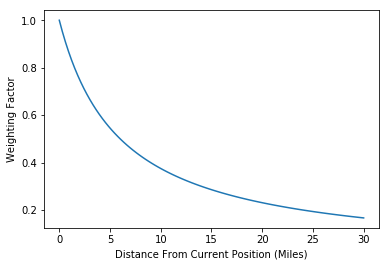

In [1283]:
x = np.linspace(0,30,100)
#y = (1/1.425)**x
y = 1-(x / (x+6))
plt.xlabel('Distance From Current Position (Miles)')
plt.ylabel('Weighting Factor')
plt.plot(x,y)